## EXAMEN 3 
### Paola Figueroa 
### 4/dic/2025

Utiliza el dataset "Advertising.csv".

- Realiza una regresión lineal simple para predecir la variable "sales" usando el resto de las variables en el dataset.
- Realiza una regresión con XGBoost para predecir la variable "sales" usando el resto de las variables en el dataset (con optimización de hiperparámetros).
- Comprueba los 6 problemas potenciales dentro del resultado encontrado en el punto 1. Modifica tu dataset/X de acuerdo a los resultados y justifica cualquier cambio realizado (añadir interacciones, quitar factores, agregar polinomios, quitar muestras, etc)
- Realiza el punto 1 con el dataset/X resultante del punto 3.
- Realiza el punto 2 con el dataset/X resultante del punto 3.
- Compara resultados entre puntos 1&4 y 2&5. ¿Qué observas?
- Optimiza tu R2 agregando transformaciones al dataset. El modelo con mejor calificación tiene 10 garantizado en el examen.

In [45]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from sklearn.metrics import roc_auc_score
from statsmodels.graphics.regressionplots import (
    plot_leverage_resid2,
    influence_plot,
)

In [2]:
data= pd.read_csv("/Users/paofigueroa/Documents/sem 5/Lab de aprendizaje estadístico/Advertising.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newspaper   200 non-null    float64
 4   sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


## parte 1: Regresión normal

In [3]:
x1=data.TV.values.reshape([-1,1])
x2=data.radio.values.reshape([-1,1])
x3=data.newspaper.values.reshape([-1,1])
y=data.sales

In [29]:
X = data.drop('sales', axis=1)
y = data['sales']

In [31]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
r2

0.8972508370448042

In [32]:
model.intercept_, model.coef_
B0= model.intercept_
Beta1=model.coef_
B0, Beta1

(3.0052094200978416,
 array([-0.00057983,  0.04577592,  0.18838318, -0.00124333]))

## Parte 2: Realiza una regresión con XGBoost con optimización de hiperparámetros.

In [6]:
# Realiza una regresión con XGBoost para predecir la variable "sales" usando el resto de las variables en el dataset (con optimización de hiperparámetros).
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
param_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}   
bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=30,
    scoring='r2',
    cv=10,
    random_state=42,
    n_jobs=-1
)
bayes_search.fit(X, y)
best_xgb = bayes_search.best_estimator_
y_pred_xgb = best_xgb.predict(X)
r2_xgb = r2_score(y, y_pred_xgb)
r2_xgb


0.9977927564707657

## Parte 3: Comprueba los 6 problemas potenciales 


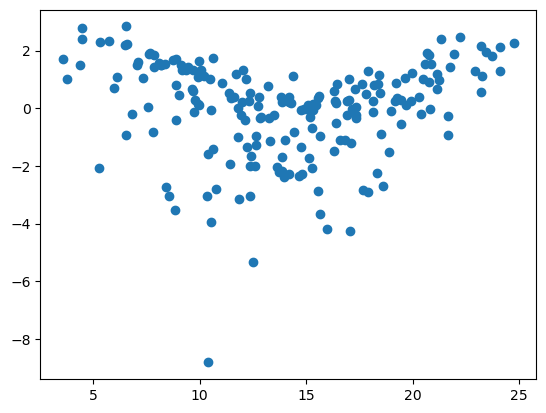

In [34]:
# 1) Linealidad
model.fit(X, y)
y_pred1 = model.predict(X)
errores = y - y_pred1

plt.scatter(y_pred1, errores)

A partir de este gráfico están distribuidos de manera aleatoria pero no siguen una línea recta, por lo que no se cumple la suposición de linealidad.

SHAPIRO-WILK NORMALITY TEST
Statistic = 0.9275, p-value = 0.0133
→ Los residuos NO son normales


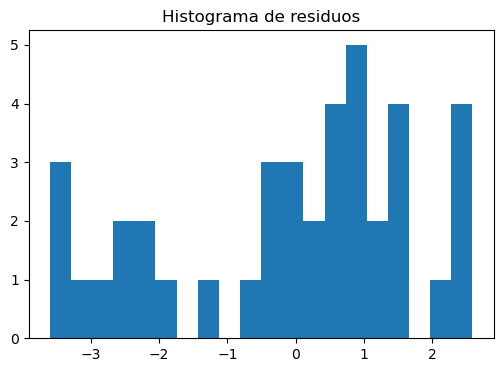

In [ ]:
# 2) Test de normalidad (este es un supuesto pero lo puse solo oara checar)
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("SHAPIRO-WILK NORMALITY TEST")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05:
    print("→ Los residuos NO son normales")
else:
    print("→ Los residuos sí parecen normales")

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20)
plt.title("Histograma de residuos")
plt.show()

Este histograma muestra que los residuos no son normales, ya que no siguen una distribición simétrica.

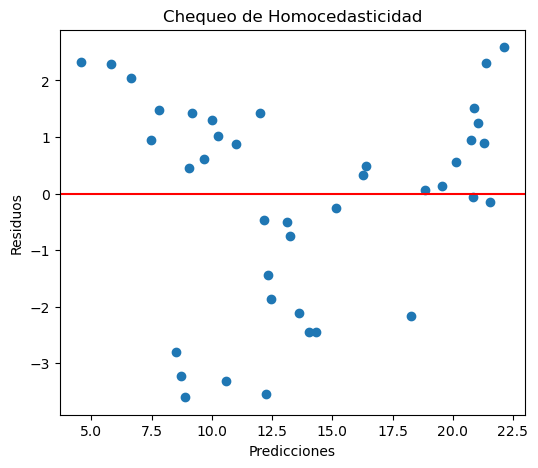

In [14]:
# 3) Homoedasticidad
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals)
plt.axhline(0, color="red")
plt.title("Chequeo de Homocedasticidad")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.show()

La línea roja representa el valor 0 de los residuos. Como podemos ver, los puntps están dispersos de manera aleatoria (sin nigún patrón) al rededor de esta linea, lo que indica que sí se cumple la homocedasticidad, pues la varianza sí es constante

In [37]:
# 4) Independencia de residuos
numerador = np.sum(np.diff(residuals)**2)
denominador = np.sum(residuals**2)
dw = numerador / denominador
print(f"Durbin–Watson: {dw:.4f}")

Durbin–Watson: 1.8927


El coeficiente de Durbin-Watson varía entre 0 y 4. Un valor cercano a 2 indica que no hay autocorrelación en los residuos. Valores por debajo de 2 sugieren autocorrelación positiva, mientras que valores por encima de 2 indican autocorrelación negativa. En este caso, el valor de 1.89 sugiere que no hay autocorrelación significativa en los residuos, lo que significa que los residuos sí son independientes

In [20]:
# 5) Multicolineadlidad
X_df = pd.DataFrame(X, columns=["TV", "radio", "newspaper"])

factor_varianza = []

for col in X_df.columns:
    X_temp = X_df.drop(columns=[col])
    y_temp = X_df[col]

    lr_temp = LinearRegression()
    lr_temp.fit(X_temp, y_temp)
    r2_temp = lr_temp.score(X_temp, y_temp)

    varianza = 1 / (1 - r2_temp)
    factor_varianza.append([col, varianza])

vif_df = pd.DataFrame(factor_varianza, columns=["Variable", "Factor Varianza"])
display(vif_df)

,Variable,Factor Varianza
0,TV,1.004611
1,radio,1.144952
2,newspaper,1.145187


Desglocé cada una de las variables para poder examinar la multicolinealidad. Observando los resultados, todos tienen valores mayores a 1, lo que indica que no hay multicolinealidad entre las variables independientes. Por lo tanto, no es necesario realizar modificaciones en el conjunto de datos en este aspecto. Con multicolinealidad nos referimos a si una de las variables puede ser explicada por las otras variables independientes en el modelo. En este caso, ninguna variable puede ser explicada por las otras.

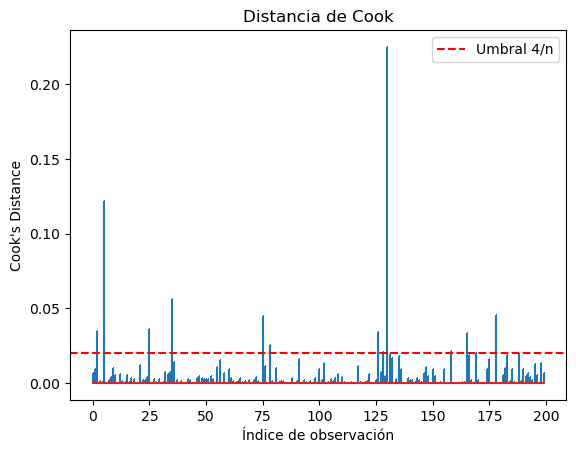

In [48]:
# Outliers
X_sm = sm.add_constant(X)  
model = sm.OLS(y, X_sm).fit()
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Visualización
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(4/len(cooks_d), color='red', linestyle='--', label='Umbral 4/n')
plt.title("Distancia de Cook")
plt.xlabel("Índice de observación")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

Hay al menos 10 outliers, sobre todo uno que brinca demasiado, lo que indica que puede estar afectando el modelo de manera significativa.

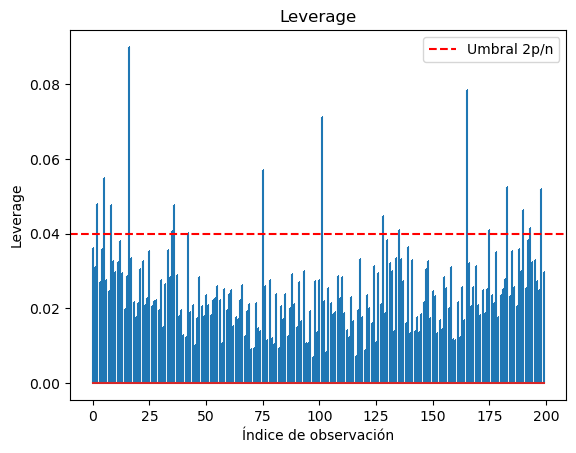

In [49]:
# Puntos palanca
leverage = influence.hat_matrix_diag
plt.stem(np.arange(len(leverage)), leverage, markerfmt=",")
plt.axhline(2*X.shape[1]/len(leverage), color='red', linestyle='--', label='Umbral 2p/n')
plt.title("Leverage")
plt.xlabel("Índice de observación")
plt.ylabel("Leverage")
plt.legend()
plt.show()

Los puntos palanca indican que hay observaciones que tienen un gran impacto en la estimación de los coeficientes del modelo.

### Modificaciones por hacer

In [54]:
# Vamos a corregir los problemas que están mal: eliminar outliers, puntos palanca y corregir la linealidad

#Quitamos outliers
influential_points = np.where(cooks_d > 4/len(cooks_d))[0]
#Quitamos puntos palanca
leverage = influence.hat_matrix_diag
high_leverage_points = np.where(leverage > 2*X.shape[1]/len(leverage))[0]
indices_to_drop = np.union1d(influential_points, high_leverage_points)
X_cleaned = X.drop(index=X.index[indices_to_drop])
y_cleaned = y.drop(index=y.index[indices_to_drop])

print(f"Filas eliminadas: {len(indices_to_drop)}")

# Corregimos la linealidad con alguna transformación (polinomios o logaritmos)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_cleaned)
model_final = LinearRegression()
model_final.fit(X_poly, y_cleaned)
y_final_pred = model_final.predict(X_poly)
r2_final = r2_score(y_cleaned, y_final_pred)
r2_final

# reentrenamos el modelo final con los datos corregidos
model_final.fit(X_poly, y_cleaned)
y_final_pred = model_final.predict(X_poly)
r2_final = r2_score(y_cleaned, y_final_pred)
r2_final



Filas eliminadas: 23


0.990158379563551

### Parte 4: hacemos una regresión lineal con el modelo final

In [57]:
model_final = LinearRegression()
model_final.fit(X_poly, y_cleaned)
y_final_pred = model_final.predict(X_poly)
r2_final = r2_score(y_cleaned, y_final_pred)
r2_final

0.990158379563551

En el primer modelo, había sacado un R2 de 0.8972508370448042, mientras que en este fue casi perfecto de 0.99, lo que significa que las transformaciones que se aplicaron representa una mejor salida del modelo

### Parte 5: XGBoost con modelo final

In [58]:
#Realiza una regresión con XGBoost para predecir la variable "sales" usando el resto de las variables CON EL MODELO FINAL en el dataset (con optimización de hiperparámetros).
xgb_final = XGBRegressor(objective='reg:squarederror', random_state=42)
param_space_final = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}   
bayes_search_final = BayesSearchCV(
    estimator=xgb_final,
    search_spaces=param_space_final,
    n_iter=30,
    scoring='r2',
    cv=10,
    random_state=42,
    n_jobs=-1
)
bayes_search_final.fit(X_poly, y_cleaned)
best_xgb_final = bayes_search_final.best_estimator_
y_pred_xgb_final = best_xgb_final.predict(X_poly)
r2_xgb_final = r2_score(y_cleaned, y_pred_xgb_final)
r2_xgb_final

0.9981154570944281

De haber tenido un XGBoost de 0.9977927564707657, ahora tuve uno muuuy bueno de 0.9981154570944281. Esta mejora en resultados indica que la limpieza y transformacipon de los dataset fue buena, ya que mejoró muchísimo el desempeño del modelo. 

### Optimización de R2 (honestamente ya tengo un buen modelo, pero lo haré por si las dudas)

In [61]:
def objective(params):
    n_estimators, max_depth, learning_rate, subsample, colsample_bytree = params
    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    xgb.fit(X_poly, y_cleaned)
    y_pred = xgb.predict(X_poly)
    r2 = r2_score(y_cleaned, y_pred)
    return -r2 

In [62]:
search_space = [
    Integer(50, 500, name='n_estimators'),
    Integer(3, 10, name='max_depth'),
    Real(0.01, 0.3, prior='log-uniform', name='learning_rate'),
    Real(0.5, 1.0, name='subsample'),
    Real(0.5, 1.0, name='colsample_bytree')
]
result = gp_minimize(
    objective,
    search_space,
    n_calls=30,
    random_state=42
)
best_params = result.x
best_params

[423, 10, 0.29999999999999993, 0.5, 0.5]

In [63]:
# Ahora optimizamos los mejores parámetros encontrados
best_params = result.x
best_params
best_xgb_optimized = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params[0],
    max_depth=best_params[1],
    learning_rate=best_params[2],
    subsample=best_params[3],
    colsample_bytree=best_params[4],
    random_state=42
)
best_xgb_optimized.fit(X_poly, y_cleaned)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.29999999999999993, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=423, n_jobs=None,
             num_parallel_tree=None, ...)

In [64]:
y_pred_xgb_optimized = best_xgb_optimized.predict(X_poly)
r2_xgb_optimized = r2_score(y_cleaned, y_pred_xgb_optimized)
r2_xgb_optimized    

0.9999999935118535

Honestamente, no sé si esto este correcto o haya mucho riesgo de overfit, pues es un modelo bastante perfecto. A la hora de predecir con XGBoost optimizado, me da un R2 de 0.9999, lo cual es sospechoso.